In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', #mostly controls relative sizes of things on plot 
                        #The base context is “notebook”, and the other contexts are “paper”, “talk”, and “poster”
        style = 'darkgrid', #dict, None, or one of {darkgrid, whitegrid, dark, white, ticks}
        palette = 'deep', # Should be something that color_palette() can process.
        font_scale = 1, 
        color_codes = False, 
        rc = None)

# from IPython.core.interactiveshell import InteractiveShell 
# InteractiveShell.ast_node_interactivity = 'last_expr' 
# setting = "all" allows multiple outputs to be displayed for a given input cell. don't use w plotting!

from IPython.display import display

%matplotlib notebook
##%matplotlib inline

pd.__version__ , np.__version__ #,  matplotlib.__version__, sns.__version__

('0.23.3', '1.14.2')

In [2]:
from sklearn.model_selection import train_test_split, learning_curve, KFold, StratifiedKFold, \
                                    ShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_val_predict

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.externals import joblib

In [3]:
cd '/Users/DonBunk/Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk/'

/Users/DonBunk/Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk


In [4]:
from Home_Credit_package.master_pipeline import master_pipeline
from Home_Credit_package.Dons_functions import balanced_sample

In [5]:
model_save_path = 'saved_models/level_2_models/'

# load this

## load df.

In [6]:
o_path = 'wrangling/TRAINING_DATA_create_final_wrangled_csv/'
L1_mf_path = 'level_1_ensembling/'
original_cleaned_df = pd.read_csv(o_path + 'complete_initial_wrangled_data.csv', index_col = 'SK_ID_CURR')
level_1_metafeatures_df = pd.read_csv(L1_mf_path + 'FINAL_level_1_meta_features_df.csv', index_col = 'SK_ID_CURR')
total_df = pd.merge(original_cleaned_df, level_1_metafeatures_df, left_index=True, right_index=True, how = 'outer' )

In [7]:
total_df.info(verbose = True, null_counts = True);

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Data columns (total 91 columns):
TARGET                               307511 non-null int64
NAME_CONTRACT_TYPE                   307511 non-null object
CODE_GENDER                          307511 non-null object
FLAG_OWN_CAR                         307511 non-null object
FLAG_OWN_REALTY                      307511 non-null object
CNT_CHILDREN                         307511 non-null int64
NAME_EDUCATION_TYPE                  307511 non-null object
NAME_FAMILY_STATUS                   307511 non-null object
DAYS_BIRTH                           307511 non-null int64
FLAG_EMP_PHONE                       307511 non-null int64
FLAG_WORK_PHONE                      307511 non-null int64
FLAG_PHONE                           307511 non-null int64
FLAG_EMAIL                           307511 non-null int64
CNT_FAM_MEMBERS                      307511 non-null int64
REGION_RATING_CLIENT                 307511 non-null

In [8]:
# CHECK: this should be empty if everything is non null
total_df.isnull().any()[total_df.isnull().any()==True]

Series([], dtype: bool)

In [9]:
raw_level_2_new_features_df = pd.DataFrame(total_df.index)
raw_level_2_new_features_df.set_index('SK_ID_CURR', inplace=True)

# models with only EXT SOURCES + level 1 final scores.                                     

In [10]:
minimal_feats = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
                 'pwr_rescale_RanFor_EXTpoly', 'pwr_rescale_RanFor_AllFeats', 
                 'pwr_rescale_LogReg_EXTpoly','pwr_rescale_LogReg_AllFeats', 
                 'pwr_rescale_MLP_AllFeats']

In [11]:
total_df_piped, final_feature_list, total_pipeline, trans_list = master_pipeline(df_in = total_df[minimal_feats],
                                                                                 int_cutoff=20, 
                                                                                 poly_deg=4, 
                                                                                 feats_with_interaction=[]
                                                                                 )

Total original feat len is 8. Sum of feats is 8.
Final array is length 40. final feature list is length 40.


In [12]:
# have to use same folds as from level 1 metafeature creation!
# this has to be loaded each time bc iteration is 'used up'
my_StrKFold = StratifiedKFold(n_splits = 3, 
                              shuffle = True,
                              random_state = 0)

my_folds = my_StrKFold.split(total_df, total_df['TARGET'])

### random forest

In [13]:
# have to use same folds as from level 1 metafeature creation!
# this has to be loaded each time bc iteration is 'used up'
my_StrKFold = StratifiedKFold(n_splits = 3, 
                              shuffle = True,
                              random_state = 0)

my_folds = my_StrKFold.split(total_df, total_df['TARGET'])

param_dist_dict =  { 'max_depth':6,
                     'min_samples_leaf':11,
                     'min_samples_split':2, 
                     'n_estimators':40,
                    }

forest_reg = RandomForestClassifier(random_state=0,
                                    class_weight = None,
                                    **param_dist_dict,
                                   )

cross_val_preds = cross_val_predict(estimator = forest_reg, 
                                      X = total_df_piped,
                                      y = total_df['TARGET'], 
                                      groups = None,
                                      cv = my_folds,
                                      n_jobs = -1,
                                      verbose = 51,
                                      fit_params = None, 
                                      pre_dispatch = '2*n_jobs', 
                                      method = 'predict_proba')

Memmaping (shape=(307511, 40), dtype=float64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4316237608/10792-112256359672-b6ec14b94b7e98261af04adf479938df.pkl
Memmaping (shape=(307511,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4316237608/10792-112256359672-7fee98903a11851f0c36b343c7ef5338.pkl
Memmaping (shape=(205007,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4316237608/10792-112256359672-617b94b8ee1dd73b53ff7a38ec2f741c.pkl
Memmaping (shape=(205007,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4316237608/10792-112256359672-49dd99a20eff7bff76798131d715d7ea.pkl
Memmaping (shape=(205008,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4316237608/10792-112256359672-20227521c910aa39c9819320f3625345.pkl
[Parallel(

In [14]:
val_scores = [x[1]for x in cross_val_preds]

In [15]:
raw_level_2_new_features_df['RanFor_EXTpoly_Level2'] = val_scores

In [16]:
roc_auc_score(total_df['TARGET'], val_scores)

0.7683671572255159

In [17]:
# fit and save model for predictions
forest_reg.fit(X = total_df_piped,
               y = total_df['TARGET'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [18]:
joblib.dump(forest_reg, model_save_path + 'RanFor_EXTpoly_level_2.joblib')

['saved_models/level_2_models/RanFor_EXTpoly_level_2.joblib']

### log reg

In [19]:
# have to use same folds as from level 1 metafeature creation!
# this has to be loaded each time bc iteration is 'used up'
my_StrKFold = StratifiedKFold(n_splits = 3, 
                              shuffle = True,
                              random_state = 0)

my_folds = my_StrKFold.split(total_df, total_df['TARGET'])

my_LgRg = LogisticRegression(penalty= 'l2', 
                             random_state = 0, 
                             class_weight = None,
                             C = 88.0) 

cross_val_preds = cross_val_predict(estimator = my_LgRg, 
                                      X = total_df_piped,
                                      y = total_df['TARGET'], 
                                      groups = None,
                                      cv = my_folds,
                                      n_jobs = -1,
                                      verbose = 51,
                                      fit_params = None, 
                                      pre_dispatch = '2*n_jobs', 
                                      method = 'predict_proba'
                                   )



Memmaping (shape=(307511, 40), dtype=float64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349738568/10792-112256358944-b6ec14b94b7e98261af04adf479938df.pkl
Memmaping (shape=(307511,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349738568/10792-112256358944-7fee98903a11851f0c36b343c7ef5338.pkl
Memmaping (shape=(205007,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349738568/10792-112256358944-617b94b8ee1dd73b53ff7a38ec2f741c.pkl
Memmaping (shape=(205007,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349738568/10792-112256358944-49dd99a20eff7bff76798131d715d7ea.pkl
Memmaping (shape=(205008,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349738568/10792-112256358944-20227521c910aa39c9819320f3625345.pkl
[Parallel(

In [20]:
val_scores = [x[1]for x in cross_val_preds]

raw_level_2_new_features_df['LogReg_EXTpoly_Level2'] = val_scores

In [21]:
roc_auc_score(total_df['TARGET'],val_scores)

0.7686470523637944

In [22]:
# fit and save model for predictions
my_LgRg.fit(X = total_df_piped,
            y = total_df['TARGET'])

LogisticRegression(C=88.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
joblib.dump(my_LgRg, model_save_path + 'LogReg_EXTpoly_level_2.joblib')

['saved_models/level_2_models/LogReg_EXTpoly_level_2.joblib']

### MLP Classifier.

In [24]:
param_dist_dict =  { 'alpha' :         .15,
                    'hidden_layer_sizes' : (67, ),
                    }

In [25]:
# have to use same folds as from level 1 metafeature creation!
# this has to be loaded each time bc iteration is 'used up'
my_StrKFold = StratifiedKFold(n_splits = 3, 
                              shuffle = True,
                              random_state = 0)

my_folds = my_StrKFold.split(total_df, total_df['TARGET'])

my_MLP = MLPClassifier(random_state=0, 
                       tol=0.0001, 
                     #  verbose=51, 
                       warm_start=False, 
                       momentum=0.9,
                       **param_dist_dict)


cross_val_preds = cross_val_predict(estimator = my_MLP, 
                                      X = total_df_piped,
                                      y = total_df['TARGET'], 
                                      groups = None,
                                      cv = my_folds,
                                      n_jobs = -1,
                                      verbose = 51,
                                      fit_params = None, 
                                      pre_dispatch = '2*n_jobs', 
                                      method = 'predict_proba')

Memmaping (shape=(307511, 40), dtype=float64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349738736/10792-112256359784-b6ec14b94b7e98261af04adf479938df.pkl
Memmaping (shape=(307511,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349738736/10792-112256359784-7fee98903a11851f0c36b343c7ef5338.pkl
Memmaping (shape=(205007,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349738736/10792-112256359784-617b94b8ee1dd73b53ff7a38ec2f741c.pkl
Memmaping (shape=(205007,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349738736/10792-112256359784-49dd99a20eff7bff76798131d715d7ea.pkl
Memmaping (shape=(205008,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349738736/10792-112256359784-20227521c910aa39c9819320f3625345.pkl
[Parallel(

In [26]:
val_scores = [x[1]for x in cross_val_preds]

raw_level_2_new_features_df['MLP_EXTpoly_Level2'] = val_scores

In [27]:
# fit and save model for predictions
my_MLP.fit(X = total_df_piped,
           y = total_df['TARGET'])

MLPClassifier(activation='relu', alpha=0.15, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(67,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [28]:
joblib.dump(my_MLP, model_save_path + 'MLP_EXTpoly_level_2.joblib')

['saved_models/level_2_models/MLP_EXTpoly_level_2.joblib']

# models with all features

In [29]:
total_df_piped, final_feature_list, total_pipeline, trans_list = master_pipeline(df_in = total_df,
                                                                                 int_cutoff=20, 
                                                                                 poly_deg=4, 
                                                                                 feats_with_interaction=[]
                                                                                 )

Total original feat len is 90. Sum of feats is 90.
Final array is length 443. final feature list is length 443.


In [30]:
my_StrKFold = StratifiedKFold(n_splits = 3, 
                              shuffle = True,
                              random_state = 0)

my_folds = my_StrKFold.split(total_df, total_df['TARGET'])

### random forest

In [31]:
# have to use same folds as from level 1 metafeature creation!
# this has to be loaded each time bc iteration is 'used up'
my_StrKFold = StratifiedKFold(n_splits = 3, 
                              shuffle = True,
                              random_state = 0)

my_folds = my_StrKFold.split(total_df, total_df['TARGET'])

param_dist_dict =  { 'max_depth' :         16,
                     'min_samples_leaf' :  550,
                     'min_samples_split' : 2, 
                     'n_estimators':       40,
                    }

forest_reg = RandomForestClassifier(random_state=0,
                                    class_weight = None,
                                    **param_dist_dict)

cross_val_preds = cross_val_predict(estimator = forest_reg, 
                                      X = total_df_piped,
                                      y = total_df['TARGET'], 
                                      groups = None,
                                      cv = my_folds,
                                      n_jobs = -1,
                                      verbose = 51,
                                      fit_params = None, 
                                      pre_dispatch = '2*n_jobs', 
                                      method = 'predict_proba')

Memmaping (shape=(79337838,), dtype=int32) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_112256452648/10792-111999951312-83d81779c0a161e9d1e756b375ef8701.pkl
Memmaping (shape=(307512,), dtype=int32) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_112256452648/10792-111999951312-511e4e07e852e42372cd1047cfce8c24.pkl
Memmaping (shape=(79337838,), dtype=float64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_112256452648/10792-111999951312-bb0f2fc11be951d7119859e152f852f0.pkl
Memmaping (shape=(307511,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_112256452648/10792-111999951312-7fee98903a11851f0c36b343c7ef5338.pkl
Memmaping (shape=(205007,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_112256452648/10792-111999951312-617b94b8ee1dd73b53ff7a38ec2f741c.pkl

In [32]:
val_scores = [x[1]for x in cross_val_preds]

raw_level_2_new_features_df['RanFor_AllFeats_Level2'] = val_scores

In [33]:
roc_auc_score(total_df['TARGET'],val_scores)

0.7674439691425369

In [34]:
# fit and save model for predictions
forest_reg.fit(X = total_df_piped,
               y = total_df['TARGET'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=550, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [35]:
joblib.dump(forest_reg, model_save_path + 'RanFor_AllFeats_level_2.joblib')

['saved_models/level_2_models/RanFor_AllFeats_level_2.joblib']

### log reg

In [36]:
# have to use same folds as from level 1 metafeature creation!
# this has to be loaded each time bc iteration is 'used up'
my_StrKFold = StratifiedKFold(n_splits = 3, 
                              shuffle = True,
                              random_state = 0)

my_folds = my_StrKFold.split(total_df, total_df['TARGET'])

my_LgRg = LogisticRegression(penalty= 'l2', 
                            random_state = 0, 
                            class_weight = None,
                            C = 179.0) 

cross_val_preds = cross_val_predict(estimator = my_LgRg, 
                                      X = total_df_piped,
                                      y = total_df['TARGET'], 
                                      groups = None,
                                      cv = my_folds,
                                      n_jobs = -1,
                                      verbose = 51,
                                      fit_params = None, 
                                      pre_dispatch = '2*n_jobs', 
                                      method = 'predict_proba')

Memmaping (shape=(79337838,), dtype=int32) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349895680/10792-112256358776-83d81779c0a161e9d1e756b375ef8701.pkl
Memmaping (shape=(307512,), dtype=int32) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349895680/10792-112256358776-511e4e07e852e42372cd1047cfce8c24.pkl
Memmaping (shape=(79337838,), dtype=float64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349895680/10792-112256358776-bb0f2fc11be951d7119859e152f852f0.pkl
Memmaping (shape=(307511,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349895680/10792-112256358776-7fee98903a11851f0c36b343c7ef5338.pkl
Memmaping (shape=(205007,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_4349895680/10792-112256358776-617b94b8ee1dd73b53ff7a38ec2f741c.pkl
Memmaping

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 39.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 39.4min finished


In [37]:
val_scores = [x[1]for x in cross_val_preds]

raw_level_2_new_features_df['LogReg_AllFeats_Level2'] = val_scores

In [38]:
roc_auc_score(total_df['TARGET'],val_scores)

0.774004179116205

In [39]:
# fit and save model for predictions
my_LgRg.fit(X = total_df_piped,
            y = total_df['TARGET'])

LogisticRegression(C=179.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
joblib.dump(my_LgRg, model_save_path + 'LogReg_AllFeats_level_2.joblib')

['saved_models/level_2_models/LogReg_AllFeats_level_2.joblib']

### MLP Classifier

In [41]:
param_dist_dict =  { 'alpha' :             .05,
                    'hidden_layer_sizes' : (55, ),
                    }

In [42]:
# have to use same folds as from level 1 metafeature creation!
# this has to be loaded each time bc iteration is 'used up'
my_StrKFold = StratifiedKFold(n_splits = 3, 
                              shuffle = True,
                              random_state = 0)

my_folds = my_StrKFold.split(total_df, total_df['TARGET'])

my_MLP = MLPClassifier(random_state=0, 
                       tol=0.0001, 
                     #  verbose=51, 
                       warm_start=False, 
                       momentum=0.9,
                       **param_dist_dict,)


cross_val_preds = cross_val_predict(estimator = my_MLP, 
                                      X = total_df_piped,
                                      y = total_df['TARGET'], 
                                      groups = None,
                                      cv = my_folds,
                                      n_jobs = -1,
                                      verbose = 51,
                                      fit_params = None, 
                                      pre_dispatch = '2*n_jobs', 
                                      method = 'predict_proba')

Memmaping (shape=(79337838,), dtype=int32) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_112256367416/10792-4316299336-83d81779c0a161e9d1e756b375ef8701.pkl
Memmaping (shape=(307512,), dtype=int32) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_112256367416/10792-4316299336-511e4e07e852e42372cd1047cfce8c24.pkl
Memmaping (shape=(79337838,), dtype=float64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_112256367416/10792-4316299336-bb0f2fc11be951d7119859e152f852f0.pkl
Memmaping (shape=(307511,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_112256367416/10792-4316299336-7fee98903a11851f0c36b343c7ef5338.pkl
Memmaping (shape=(205007,), dtype=int64) to new file /var/folders/1x/nd476hm95310c4gp98rmvwkc0000gn/T/joblib_memmaping_pool_10792_112256367416/10792-4316299336-617b94b8ee1dd73b53ff7a38ec2f741c.pkl
Memmaping

In [43]:
val_scores = [x[1]for x in cross_val_preds]

raw_level_2_new_features_df['MLP_AllFeats_Level2'] = val_scores

In [44]:
roc_auc_score(total_df['TARGET'],val_scores)

0.7652337215805917

In [45]:
# fit and save model for predictions
my_MLP.fit(X = total_df_piped,
           y = total_df['TARGET'])

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(55,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [46]:
joblib.dump(my_MLP, model_save_path + 'MLP_AllFeats_level_2.joblib')

['saved_models/level_2_models/MLP_AllFeats_level_2.joblib']

# plot so far

In [47]:
just_for_plotting_df = pd.merge(total_df, raw_level_2_new_features_df, left_index=True, right_index= True, how = 'inner') #on='SK_ID_CURR' )

In [48]:
total_df.shape, raw_level_2_new_features_df.shape, just_for_plotting_df.shape

((307511, 91), (307511, 6), (307511, 97))

In [49]:
# get a random sample bc full sample is too much to plot
this_sample = balanced_sample(just_for_plotting_df, 24000, 0)

In [50]:
['RanFor_EXTpoly_Level2', 'LogReg_EXTpoly_Level2','MLP_EXTpoly_Level2',
'RanFor_AllFeats_Level2','LogReg_AllFeats_Level2''MLP_AllFeats_Level2',];

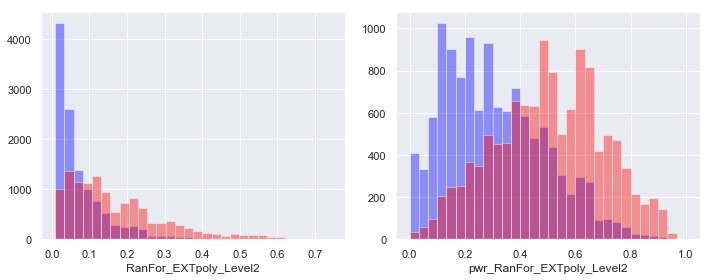

In [51]:
feat = 'RanFor_EXTpoly_Level2'
#this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = (+this_sample[feat])**(1/5)
this_sample['pwr_'+ feat] = \
(this_sample['pwr_'+ feat] - min(this_sample['pwr_'+ feat])) /( max(this_sample['pwr_'+ feat]) - min(this_sample['pwr_'+ feat]))

my_list = [feat,  'pwr_'+ feat] # 'LogMod_'+feat,
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) ][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) ][f]

    my_bins =np.histogram(  this_sample[f]  , bins = 30 )[1] 
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)
    
plt.tight_layout()

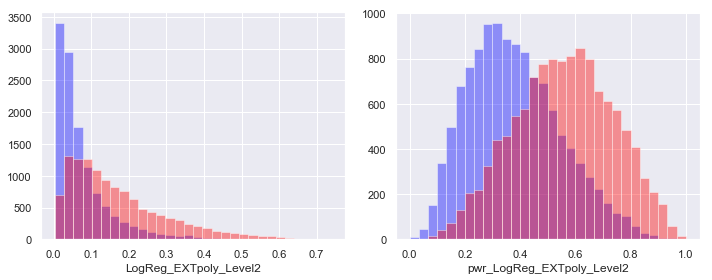

In [52]:
feat = 'LogReg_EXTpoly_Level2'
#this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = (+this_sample[feat])**(1/5)
this_sample['pwr_'+ feat] = \
(this_sample['pwr_'+ feat] - min(this_sample['pwr_'+ feat])) /( max(this_sample['pwr_'+ feat]) - min(this_sample['pwr_'+ feat]))

my_list = [feat,  'pwr_'+ feat] # 'LogMod_'+feat,
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) ][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) ][f]

    my_bins =np.histogram(  this_sample[f]  , bins = 30 )[1] 
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)
    
plt.tight_layout()

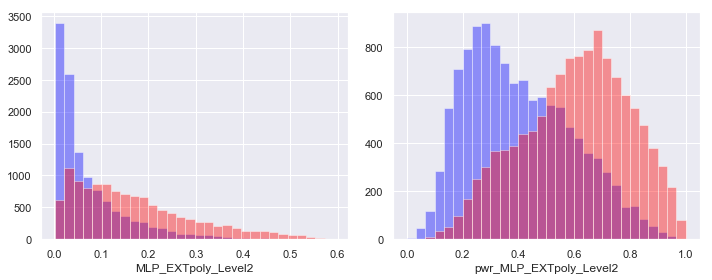

In [53]:
feat = 'MLP_EXTpoly_Level2'
#this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = (+this_sample[feat])**(1/5)
this_sample['pwr_'+ feat] = \
(this_sample['pwr_'+ feat] - min(this_sample['pwr_'+ feat])) /( max(this_sample['pwr_'+ feat]) - min(this_sample['pwr_'+ feat]))

my_list = [feat,  'pwr_'+ feat] # 'LogMod_'+feat,
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) ][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) ][f]

    my_bins =np.histogram(  this_sample[f]  , bins = 30 )[1] 
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)
    
plt.tight_layout()

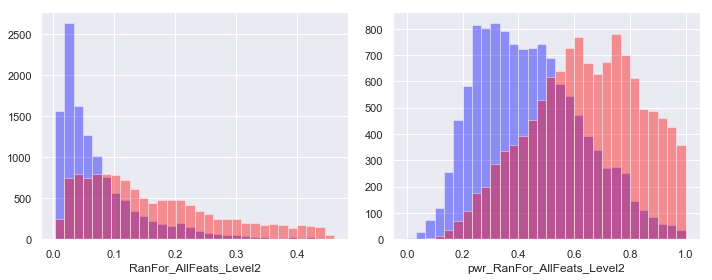

In [54]:
feat = 'RanFor_AllFeats_Level2'
#this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = (+this_sample[feat])**(1/5)
this_sample['pwr_'+ feat] = \
(this_sample['pwr_'+ feat] - min(this_sample['pwr_'+ feat])) /( max(this_sample['pwr_'+ feat]) - min(this_sample['pwr_'+ feat]))

my_list = [feat,  'pwr_'+ feat] # 'LogMod_'+feat,
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) ][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) ][f]

    my_bins =np.histogram(  this_sample[f]  , bins = 30 )[1] 
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)
    
plt.tight_layout()

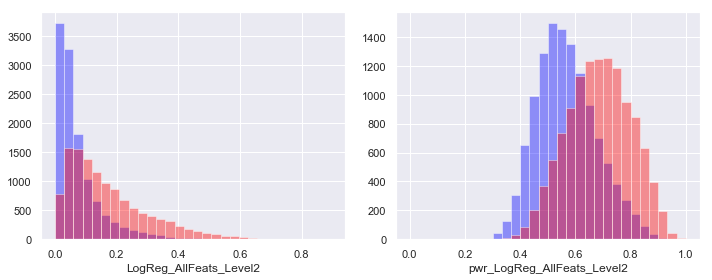

In [55]:
feat = 'LogReg_AllFeats_Level2'
#this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = (+this_sample[feat])**(1/5)
this_sample['pwr_'+ feat] = \
(this_sample['pwr_'+ feat] - min(this_sample['pwr_'+ feat])) /( max(this_sample['pwr_'+ feat]) - min(this_sample['pwr_'+ feat]))

my_list = [feat,  'pwr_'+ feat] # 'LogMod_'+feat,
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) ][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) ][f]

    my_bins =np.histogram(  this_sample[f]  , bins = 30 )[1] 
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)
    
plt.tight_layout()

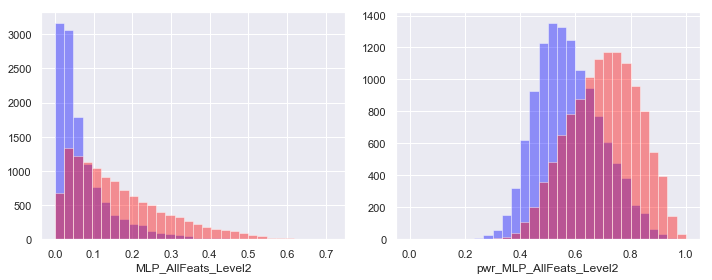

In [56]:
feat = 'MLP_AllFeats_Level2'
#this_sample['LogMod_'+ feat] = log_modulus_transformation(this_sample[feat])
this_sample['pwr_'+ feat] = (+this_sample[feat])**(1/5)
this_sample['pwr_'+ feat] = \
(this_sample['pwr_'+ feat] - min(this_sample['pwr_'+ feat])) /( max(this_sample['pwr_'+ feat]) - min(this_sample['pwr_'+ feat]))

my_list = [feat,  'pwr_'+ feat] # 'LogMod_'+feat,
num_plots = len(my_list)

fig, axs = plt.subplots(nrows = 1,
                        ncols = num_plots,
                        figsize = (num_plots*5,  4));

for f, a in zip(my_list, range(len(my_list))):   
    dat_0 = this_sample[ (this_sample['TARGET']== 0) ][f]
    dat_1 = this_sample[ (this_sample['TARGET']== 1) ][f]

    my_bins =np.histogram(  this_sample[f]  , bins = 30 )[1] 
    
    g0 = sns.distplot(dat_0, color = 'blue', ax = axs[a], kde = False, bins = my_bins)
    g1 = sns.distplot(dat_1, color = 'red',  ax = axs[a], kde = False, bins = my_bins)
    
plt.tight_layout()

# Final level 2 metafeatures

In [57]:
def pwr_and_rescale(df_col, pwr):
    temp_col = df_col**pwr
    return (temp_col - min(temp_col)) /( max(temp_col) - min(temp_col))

In [58]:
FINAL_level_2_new_features_df = pd.DataFrame()

In [59]:
feat = 'RanFor_EXTpoly_Level2'
FINAL_level_2_new_features_df['pwr_rescale_'+ feat] = pwr_and_rescale(+raw_level_2_new_features_df[feat], 1/5)

feat = 'LogReg_EXTpoly_Level2'
FINAL_level_2_new_features_df['pwr_rescale_'+ feat] = pwr_and_rescale(+raw_level_2_new_features_df[feat], 1/3.5)

feat = 'MLP_EXTpoly_Level2'
FINAL_level_2_new_features_df['pwr_rescale_'+ feat] = pwr_and_rescale(+raw_level_2_new_features_df[feat], 1/4)

feat = 'RanFor_AllFeats_Level2'
FINAL_level_2_new_features_df['pwr_rescale_'+ feat] = pwr_and_rescale(+raw_level_2_new_features_df[feat], 1/7)

feat = 'LogReg_AllFeats_Level2'
FINAL_level_2_new_features_df['pwr_rescale_'+ feat] = pwr_and_rescale(+raw_level_2_new_features_df[feat], 1/4)

feat = 'MLP_AllFeats_Level2'
FINAL_level_2_new_features_df['pwr_rescale_'+ feat] = pwr_and_rescale(+raw_level_2_new_features_df[feat], 1/4)


In [60]:
pwd

'/Users/DonBunk/Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk'

In [61]:
save_path = 'level_2_ensembling/'
FINAL_level_2_new_features_df.to_csv(save_path + 'FINAL_level_2_meta_features_df.csv', columns = list(FINAL_level_2_new_features_df.columns))